In [1]:
!pip install transformers
!pip install sentence-transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 
     |████████████████████████████████| 636 kB 50.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 1.2 MB 11.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=d9ae6bc24304c6e6278d0e656caa45622d853427be3976a137683b79dbc652a7
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers


In [22]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
# Remember to mount drive!

import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA
import re

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import random
random.seed(11777)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ROOT_DIR =  "drive/MyDrive/DecorAssist/"
DATASET_DIR = ROOT_DIR + "IKEA/text_data/"

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]') # ??
STOPWORDS = set(stopwords.words('english'))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
simple_model = BertModel.from_pretrained('bert-base-uncased')
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [3]:
def read_pickle(fn):
	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		fn: the pickle file name
	# Returns
		obj: the desired data object
	'''
	with open(fn, "rb") as f:
		return pickle.load(f)
	

def text_prepare(text):
	text = text.lower() # lowercase text
	text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
	text = re.sub(BAD_SYMBOLS_RE, "", text)      # delete symbols which are in BAD_SYMBOLS_RE from text
	text = " ".join([word for word in text.split(" ") if word not in STOPWORDS]) # delete stopwords from text
	text = re.sub('[^a-zA-Z]+', ' ', text)
	text = re.sub(' +', ' ', text)
	return text.strip()
	
def get_all_unique_words(descriptions):
	words = []
	for text in descriptions:
		text = text_prepare(text)
		words += text.split() 
	return list(set([word for word in words]))

In [51]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_info = {key : value["type"] + " " +
                             value["desc"] + " " +
                             value["name"]
                       for key, value in item_property.items()}


unique_infos = list(set(item_to_info.values()))

### EDA
1. How many labels are there for items / objects? Distribution
2. How many labels are there for rooms? Distribution
3. Most popular words for item descriptions
4. tsne and similarity function for word vectors (take two descriptions, compute score) for (item, item), (room, room), (item, room)
5. Bert encoding tsne and similarity function (take two descriptions, compute score) for (item, item), (room, room), (item, room)


## Exploratory Data Analysis

In [52]:
all_words = get_all_unique_words(unique_infos)

In [53]:
print("Total number of rooms in the dataset: ", len(room_categories.keys()))
print("Total number of items in the dataset: ", len(item_categories.keys()))
print("Number of unique room categories in the dataset: ", len(set(room_categories.values())))
print("Number of unique item categories in the dataset: ", len(set(item_categories.values())))
print("Number of unique item descriptions in the dataset: ", len(unique_infos))
print("Number of unique words in all descriptions: ", len(all_words))

Total number of rooms in the dataset:  262
Total number of items in the dataset:  2191
Number of unique room categories in the dataset:  9
Number of unique item categories in the dataset:  677
Number of unique item descriptions in the dataset:  1750
Number of unique words in all descriptions:  3092


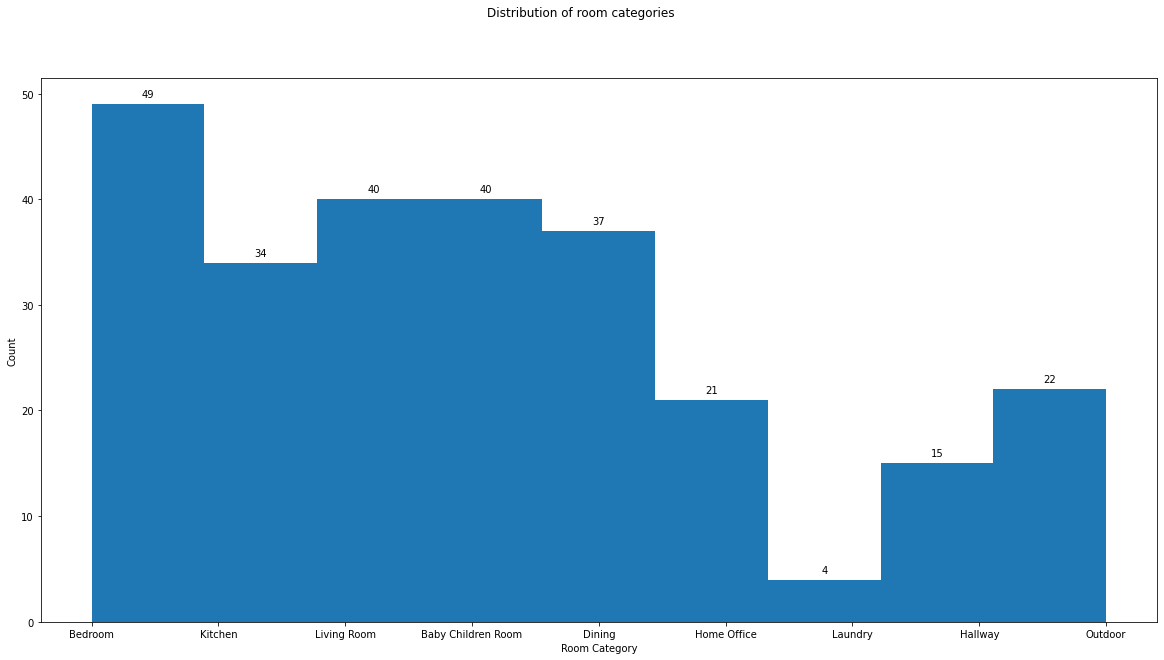

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(list(room_categories.values()), align="mid", bins=len(set(room_categories.values())))

fig.suptitle('Distribution of room categories', fontsize=12)
ax.set_xlabel('Room Category', fontsize=10)
ax.set_ylabel('Count', fontsize='medium')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

### Bert Encoding Step

In [55]:
def simple_bert_embedder(sentences):
  inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
  outputs = simple_model(**inputs)
  return torch.mean(outputs.last_hidden_state, axis=1).detach().numpy()

def sentence_bert_embedder(sentences):
  return sbert_model.encode(sentences)

def cosine_similarity(u, v):
    # compute the similarity between two embeddings
    # u and v are matrices!
    return np.einsum('ij,ij->i', u, v) / ((np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1)))

def topn(sentence, emb_func, embedding_store):
  # scores = cosine(np.repeat(emb, embedding_store.shape[0], axis=0), embedding_store)
  for desc in all_desc:
    simi_func(sentence, desc)
    append(list)
    





def simi_func(sentence1, sentence2, emb_func):
  emb1 = emb_func([sentence1])
  emb2 = emb_func([sentence2])
  return cosine_similarity(emb1, emb2)

In [60]:
unique_infos[:15]

['Play mat Different motifs, sounds and materials activate the baby and stimulate their senses and motor skills. LEKA',
 'Red wine glass The glass has a large round bowl which helps the wines aromas and flavours to develop better, enhancing your experience of the drink. RTTVIK',
 'Nest of tables, set of 2 View more product information The round shape gives you a generous table top for trays, coffee or tea services. And the neat dimensions make the table easy to place in the room. KRAGSTA',
 'Frame View more product information Can be hung horizontally or vertically to fit in the space available. MARIETORP',
 'Leg frame 25 year guarantee. Read about the terms in the guarantee brochure. SKRALID',
 'Wall upright,shelves,drying rack  ALGOT',
 'Drying rack, in,outdoor Suitable for both indoor and outdoor use. MULIG',
 'Cushion The cushion has decorative embroidery. ROSIG',
 'Alarm clock View more product information DEKAD',
 'Bed frame, high Mattress and bedlinen are sold separately. Real w

In [61]:
simi_func("Wall cabinet with 1 door View more product information 10 year guarantee. Read about the terms in the guarantee brochure. GODMORGON", 
          "Wall upright,shelves,drying rack  ALGOT", sentence_bert_embedder)

[0.35743478]


In [84]:
def tsne_plot(all_words, number_of_words, title, embed_func=simple_bert_embedder):
  all_words = sorted(all_words)
  candidate_words = []
  candidate_words = [word for i, word in enumerate(all_words) if i % int(len(all_words) / number_of_words) == 0]
  print(sorted(candidate_words))

  simple_embeddings = embed_func(candidate_words)
  word_to_emb_dict = {}
  for i in range(len(candidate_words)):
    word_to_emb_dict[candidate_words[i]] = simple_embeddings[i]
    
  # https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
  # In word_to_emb_dict, we map a word to corresponding numpy embedding vector of shape (n, )
  labels = []
  tokens = []

  for word, emb in word_to_emb_dict.items():
    tokens.append(emb)
    labels.append(word)
  
  
  tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=11777)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      
  plt.figure(figsize=(20, 20)) 
  plt.title(title)
  for i in range(len(x)):
      plt.scatter(x[i],y[i])
      plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
  plt.show()

['a', 'address', 'alone', 'armchair', 'attractive', 'barbeque', 'beech', 'birch', 'blossoming', 'bottle', 'broken', 'cab', 'catches', 'chewed', 'close', 'combination', 'connect', 'core', 'creamy', 'dalskr', 'densely', 'dinera', 'dome', 'drinks', 'dyning', 'ekne', 'enough', 'ext', 'fastening', 'fingerprintproof', 'fleece', 'footrest', 'frgrik', 'g', 'gjra', 'grains', 'grundlig', 'handknotted', 'hedblomster', 'highgloss', 'hold', 'hrliga', 'including', 'interiors', 'jrsta', 'keeping', 'knives', 'kungsholmen', 'lasts', 'leifarne', 'lightweight', 'ljusning', 'low', 'machine', 'marius', 'meets', 'mirror', 'mossebo', 'must', 'nicely', 'nskedrm', 'opal', 'outlet', 'parties', 'personalise', 'places', 'polyurethane', 'precisely', 'provided', 'ragnborg', 'really', 'remove', 'ring', 'ronglan', 'runny', 'saucepan', 'sections', 'sften', 'shower', 'sinnlig', 'slats', 'smnig', 'softer', 'sparately', 'squeaks', 'stblomster', 'stopper', 'sttta', 'supplies', 'system', 'template', 'though', 'tived', 'tos

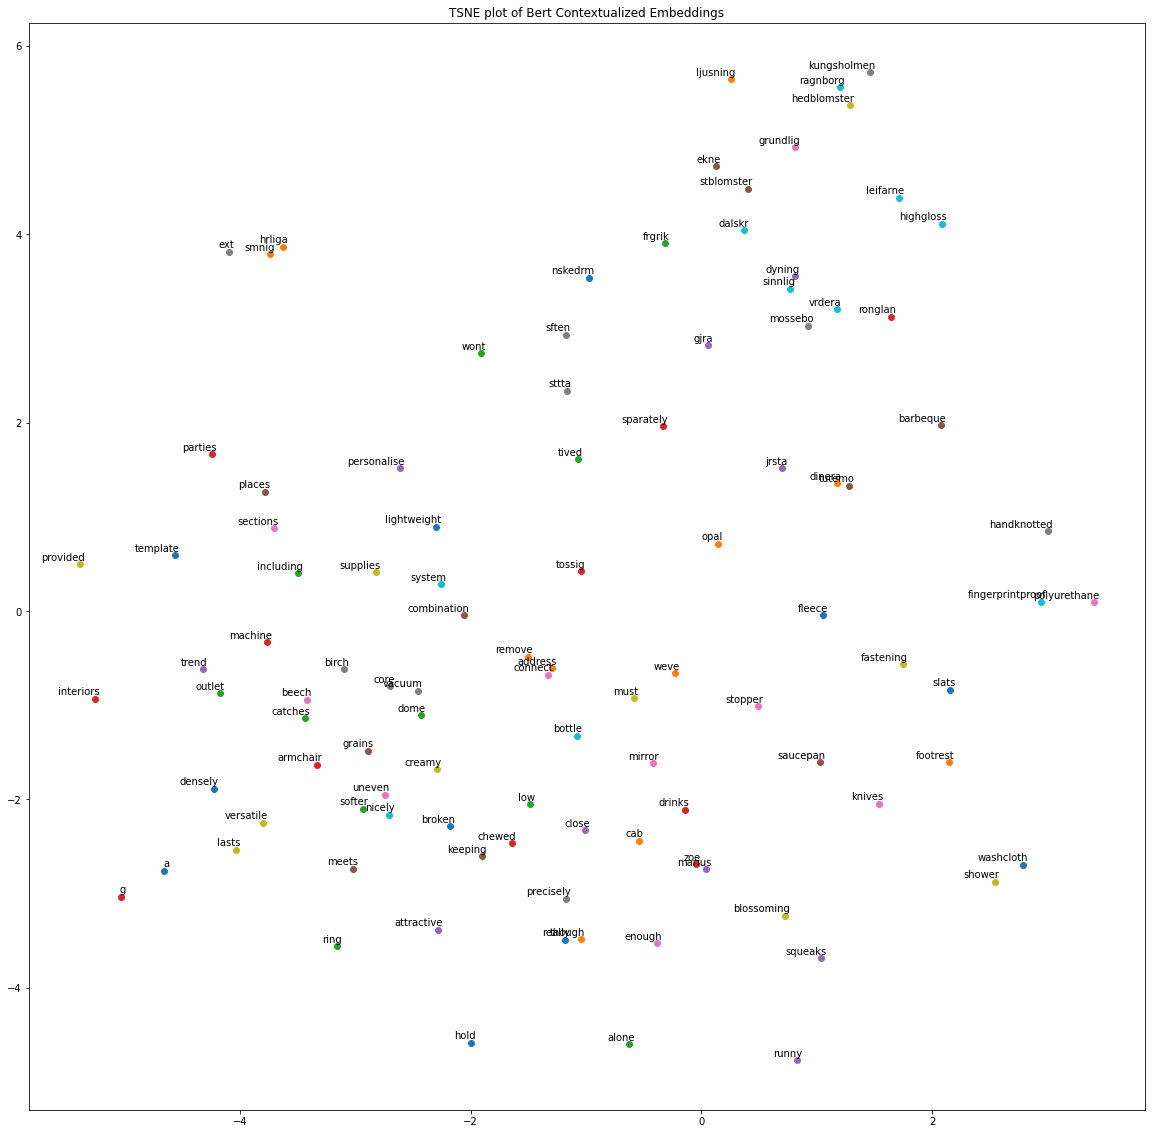

In [85]:
tsne_plot(all_words, 100, "TSNE plot of Bert Contextualized Embeddings")